# Stocks

In [ ]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

import seaborn as sns

import sys
sys.path.insert(0, '../cmds')
from utils import *
from portfolio import *

# Equities

## Capital Structure

### Funding

Assets are funded by investors, primarily via one of two types of investor claims:
* debt - senior, fixed (scheduled) claim
* equity - junior, residual claim

This is true of any assets, including
* publicly-listed companies
* privately-listed companies
* private equity funds
* hedge funds

### Stocks

Stocks are equity claims on assets of a corporation.
* Stockholders have a junior claim on the assets and income of the firm.
* Namely, they receive whatever is left over after all other claimants (suppliers, tax collectors, creditors, etc.) have been paid.
* The firm can pay out the residual as dividends or reinvest it in the firm which increases the value of the shares.

### Limited Liability

Limited liability means that shareholders are not accountable for a firm’s obligations.
* Losses are limited to the original investment.
* Equity claim is similar to a call option on a firm’s overall value.
* Compare this to unincorporated businesses where owners are personally liable.

### Market size and ownership

Of all types of capital market securities, stocks have the most market value.
* However, annual new issues are much smaller than that of corporate bonds.
* Annual new issues are less than 1% of the market value of equities.
* About half of stocks are held by individuals. 
* The other half are held by institutional investors such as pension funds, mutual funds, and insurance companies.

## Types of stock
Consider two types of stock.
* **Common stock** is a simple equity claim. It may or may not have voting rights.
* **Preferred stock** is like a hybrid of equity and debt. Like debt, it has no voting rights. 

If no specification is made, “stock” typically refers to common stock, a pure equity claim.

### Preferred stock

Consider some ways preferred is like debt and also equity.
* It has a stated dividend rate, which is similar to a coupon rate on a bond.
* Unlike a bond, the dividend does not have to be paid.
* However, common stockholders cannot be paid dividends until
preferred dividends are paid.
* In fact, usually the cumulative preferred dividend must be paid first.

#### Tax Treatment
Preferred stock has favorable tax treatment, which leads to special demand and supply of it.

### Dual Shares

Some firms have dual share classes, such as an A and B series of shares. Motives include:
- Concentrating control by giving a smaller class much higher voting power
- Ease issues with listing on various exchanges

Examples include Google, Facebook, and Berkshire Hathaway

## Stock Categorization

In trading, it is common to group equities by
- geographical location
- sector
- size 
- style

A few comments on this.

### Cap

The term "cap" typically refers to **equity capitalization** which is the total **market** value of the firm's equity.

Thus, a stock will be bucketed as **small cap, mid cap, large cap**.

### Sector / Industry
There are a number of common sector/industry classifications.

The Global Industry Classification Standard (GICS) is a popular classification, but there are many.

GICS has a top level of 11 Sectors subdivided by Industry Group, Industry and Sub-Industry.

Reference: https://www.msci.com/our-solutions/indexes/gics

## Style

**Style analysis** refers to grouping stocks by various measures.

### Book Metrics

"Book" measures refer to data from financial reporting (accounting).
- These book measures are not the same as actual market values.
- This is especially important to note for the book value of equity, the *book* capitalization.

#### Financial Statements
- balance sheet
- income statment
- statement of cashflows

#### Earnings
For now, all that will be noted about earnings is that they are a book (accounting) measure of profits, **not an actual cashflow.**

Dividends are an actual market cashflow.

### Book-to-Market

The book-to-market (B/M) ratio is the market value of equity divided by the book (balance sheet) value of equity.

High B/M means strong (accounting) fundamentals per market-value-dollar.
- High B/M are value stocks.
- Low B/M are growth stocks.

### Value and Growth
Many other measures of value based on some cash-flow or accounting value per market price.
- Earnings-price is a popular metric beyond value portfolios. Like B/M, the E/P ratio is accounting value per market valuation.
- EBITDA-price is similar, but uses accounting measure of profit that ignores taxes, financing, and depreciation.
- Dividend-price uses common dividends, but less useful for individual firms as many have no dividends.

Many competing claims to special/better measure of ‘value’.

### Other Styles
Group stocks by
- Price movement. Momentum, mean reversion, etc.
- Volatility. Realized return volatility, market beta, etc.
- Profitability.*
- Investment.*

*As measured in financial statements.

# Returns and Trading

## Common Stock Returns

Unlike bonds, common stocks do NOT have a
* maturity
* (relevant) face value

Rather, the notable features determining returns are
* dividends
* price appreciation

## Dividends

In [ ]:
INFILE = f'../data/equity_data.xlsx'
TICK = 'AAPL'
TICKETF = 'SPY'
TICKIDX = 'SPX'

In [ ]:
dvds = pd.read_excel(INFILE,sheet_name=f'dividends {TICK}').set_index('record_date')
dvds[dvds['dividend_type']=='Regular Cash'].head(8).style.set_caption(f'Dividends for {TICK}.')

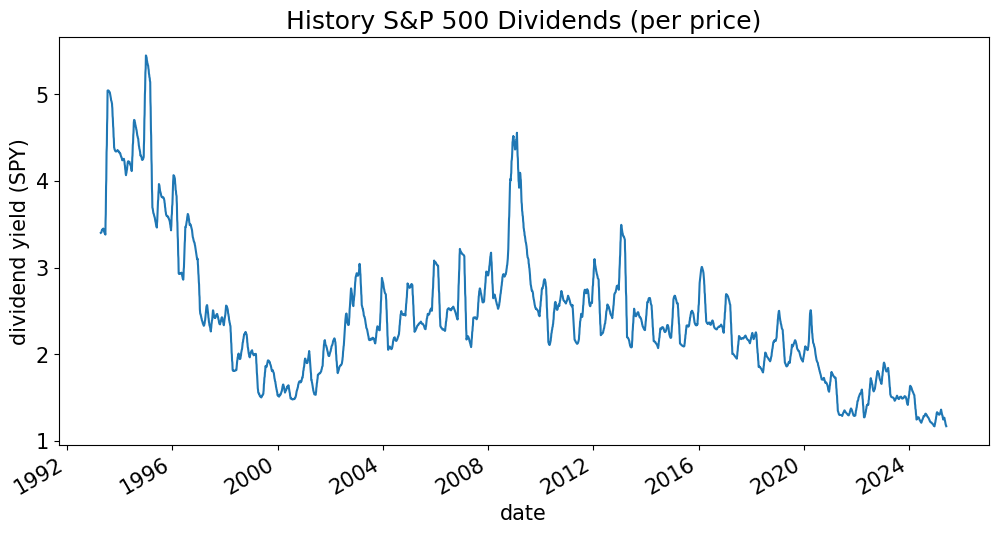

In [ ]:
spy = pd.read_excel(INFILE,sheet_name=f'{TICKETF} history').set_index('date')
spy['EQY_DVD_YLD_IND'].rolling(21).mean().plot(title='History S&P 500 Dividends (per price)',ylabel=('dividend yield (SPY)'));

## Corporate Actions

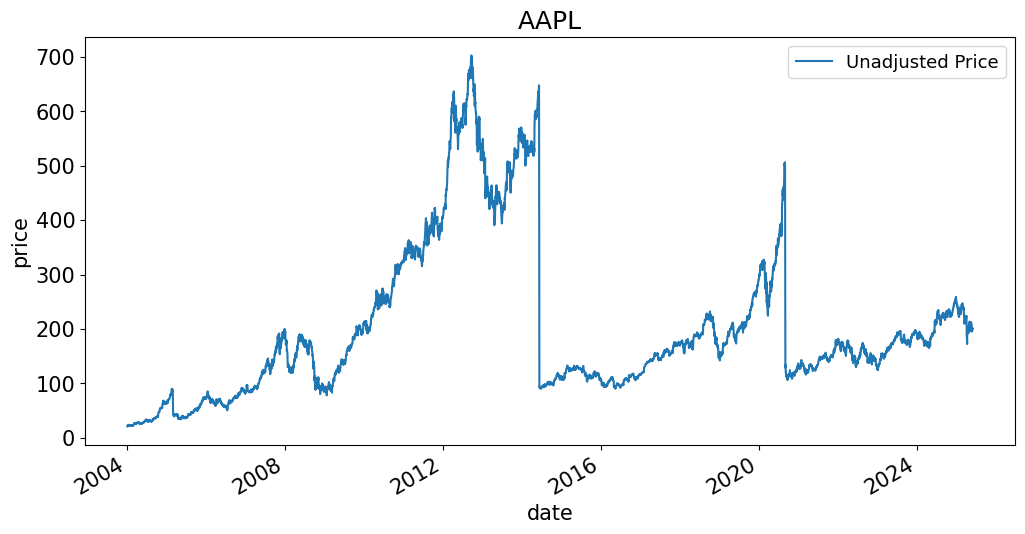

In [ ]:
prices = pd.read_excel(INFILE,sheet_name=f'prices {TICK}').set_index('date')

prices['Unadjusted Price'].plot(title=TICK, ylabel='price', legend=['unadjusted price']);

What is going on here? 
- Has Apple really shown so little growth since 2005?
- Has Apple really crashed so hard?

In [ ]:
dvds[dvds['dividend_type']=='Stock Split'].rename(columns={'dividend_amount':'split ratio'}).loc[:,['split ratio']].style.set_caption(f'{TICK}')

## Adjusted Prices

The **adjusted** price is
* the same as the actual price on the final value of the timeseries.
* readjusted backward through time, so earlier dates may diverge greatly
* ensures a historically accurate return series can be computed

The adjusted price incorporates
* regular dividends
* special dividends
* stock splits

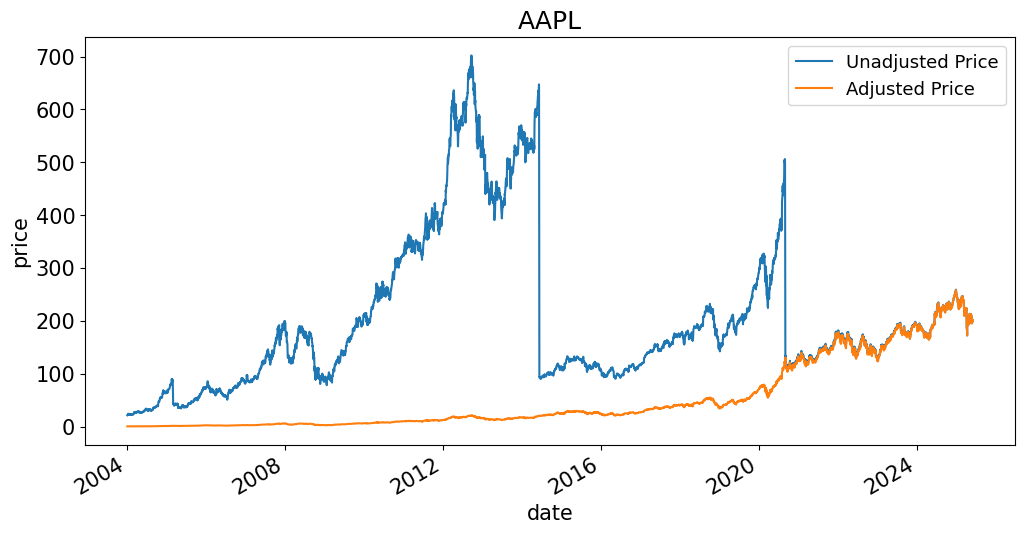

In [ ]:
prices[['Unadjusted Price','Adjusted Price']].plot(title=TICK, ylabel='price');

### <span style="background-color:LightSteelBlue">Technical Point: Computation of adjusted price</span>

Notation:
$P$: unadjusted price
$P^*$: adjusted price
$D$: dividend

We want an adjusted price series such that returns are correct, without further adjustment:

$$\frac{P_{t+1} + D_{t+1}}{P_t} = \frac{P_{t+1}^*}{P^*_t}$$

#### Footnote
Adjusted prices (for dividends) are reported in a way that is slightly biased, and does not lead to a completely equivalent return on dividend days. Data providers typically calculate:

$$P^*_t = P_t\prod_{t_i}A_i $$

where the $t_i$ denote the ex-dividend dates such that $t_i > t$. Namely, each dividend causes an additional adjustment factor, $A_i$ for all dates preceding the dividend.

The scaling is given by

$$A_i = 1 - \frac{D_{t_i}}{P_{{t_i}-1}}$$

However, the conversion factor needed to ensure the adjusted series gives identical returns is

$$A_i = \frac{P_{t_i}}{P_{t_i}+D_{t_i}}$$

In practice, this difference is very small, and everyone uses adjusted returns without worrying about this bias.

Still, if you are calculating a dividend-adjusted return by hand from the unadjusted prices, it will not quite match the price growth of the adjusted-price series.

### International Stocks

American Depository Receipts (ADR’s) are certificates traded in U.S. markets which represent foreign stocks.
* ADR’s are used to make it easier for foreign firms to register securities in the U.S.
* Most foreign stocks traded in U.S. markets use ADRs.
* Sometimes, these are called American Depository Shares, or ADS.

***

# SPX Sector Metrics

### Load Data

In [ ]:
from matplotlib.cm import get_cmap
from matplotlib import patches as mpatches

In [ ]:
FILE_DATA = '../data/spx_metrics.xlsx'

with pd.ExcelFile(FILE_DATA) as xls:
    bdp_df = pd.read_excel(xls, sheet_name='Single Name Stats', index_col='ticker')
    sector_metrics = pd.read_excel(xls, sheet_name='Sector Stats', index_col='gics_sector_name')
    names = pd.read_excel(xls, sheet_name='Ticker Names', index_col='ticker')

# Normalize column names to lower-case
bdp_df.columns = [c.lower() for c in bdp_df.columns]
sector_metrics.columns = [c.lower() for c in sector_metrics.columns]

In [ ]:
metrics = bdp_df.columns
# Map ticker to sector for coloring
ticker_to_sector = bdp_df['gics_sector_name']
# Prepare sector color map
sectors = sector_metrics.index.tolist()
cmap = get_cmap('tab20', len(sectors))
color_map = {s: cmap(i) for i, s in enumerate(sectors)}

/var/folders/zx/3v_qt0957xzg3nqtnkv007d00000gn/T/ipykernel_85347/605429811.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20', len(sectors))


## Sector Stats

/var/folders/zx/3v_qt0957xzg3nqtnkv007d00000gn/T/ipykernel_85347/2578127923.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20', len(sectors))


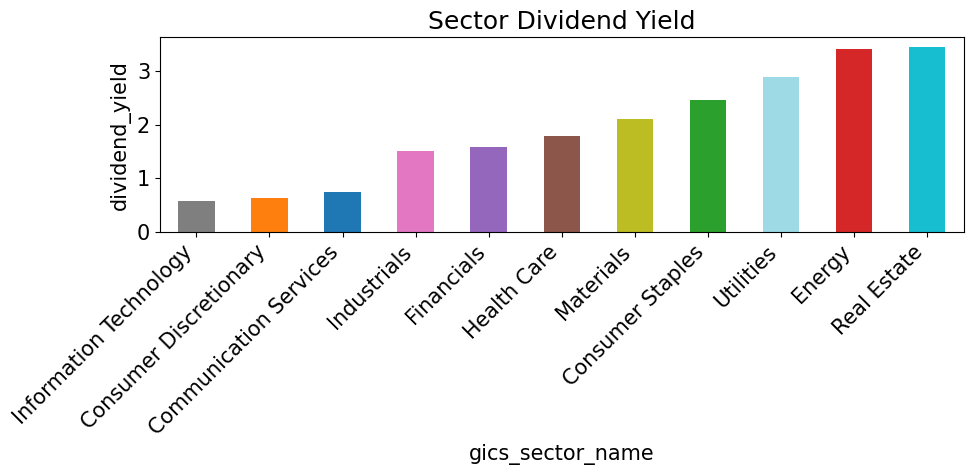

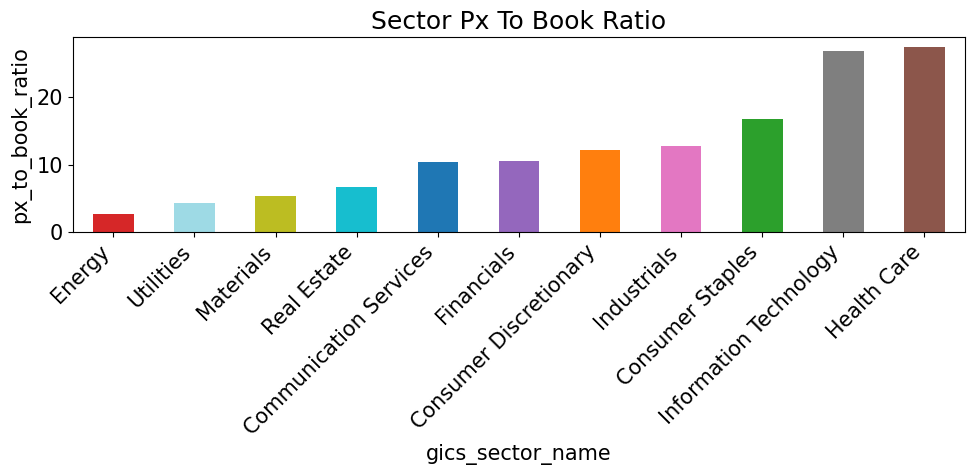

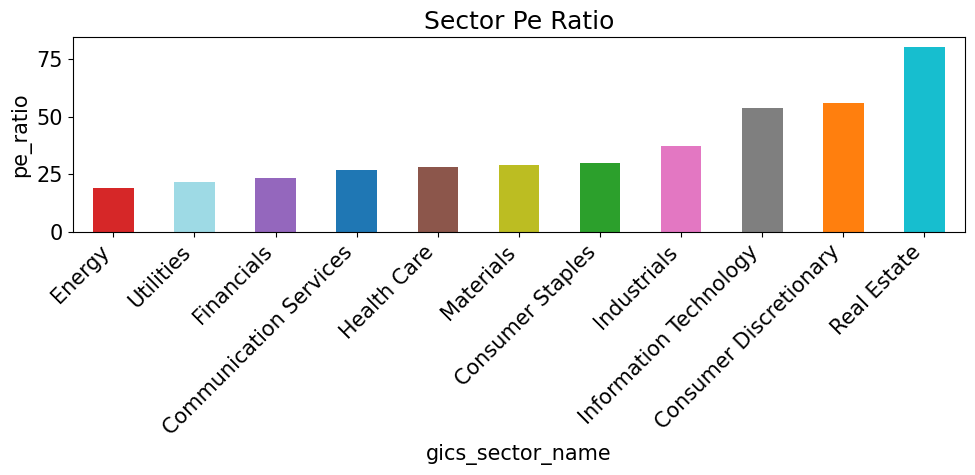

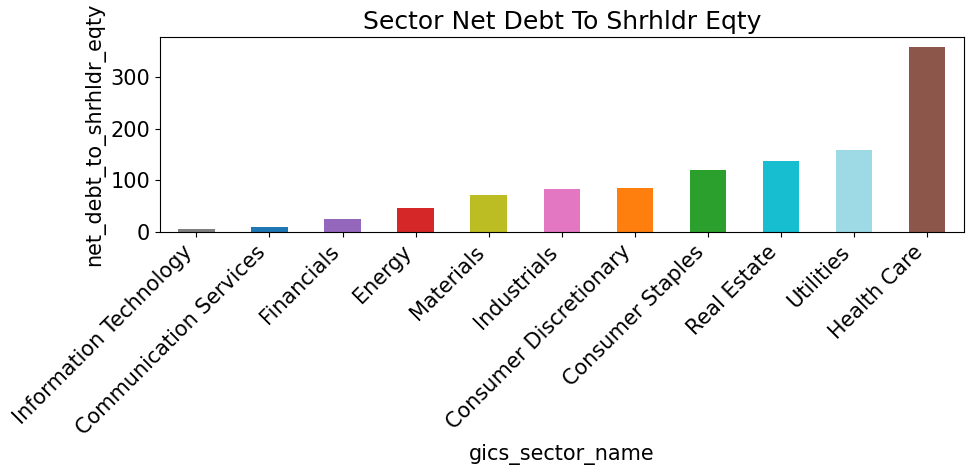

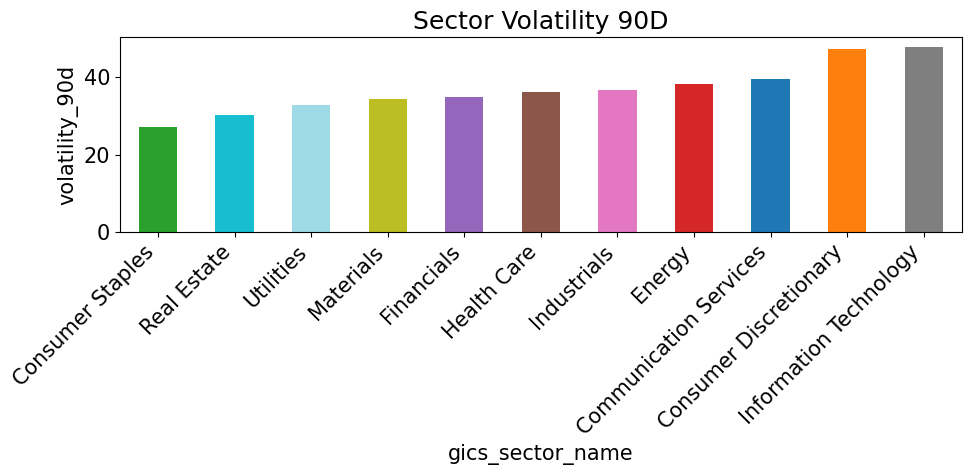

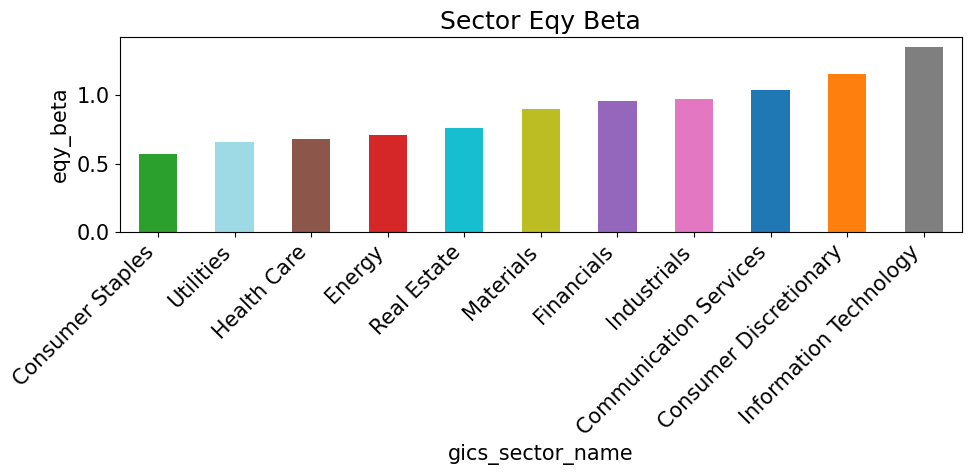

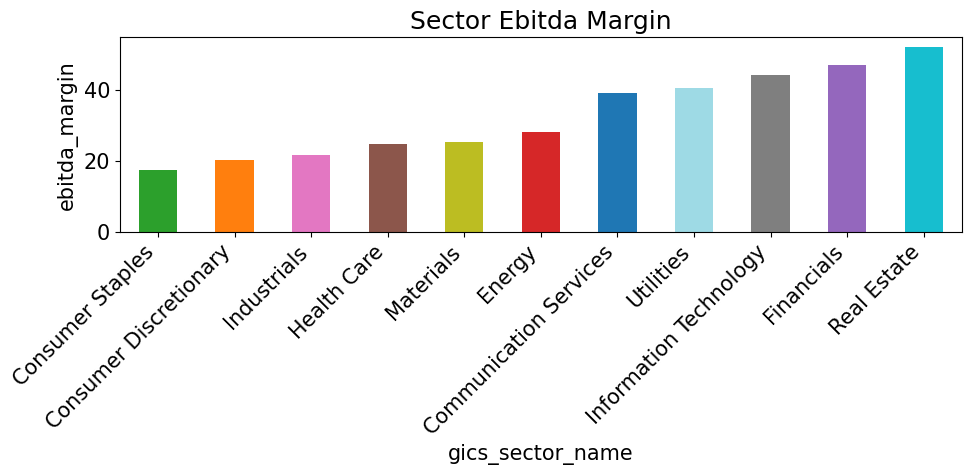

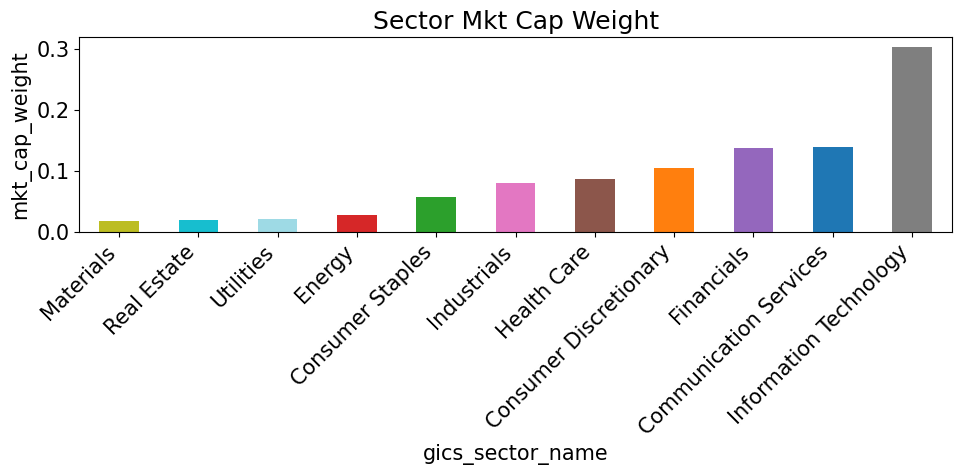

In [ ]:
# ----------------------------------------
# PREPARE SECTOR COLOR MAP
# ----------------------------------------
sectors = sector_metrics.index.tolist()
cmap = get_cmap('tab20', len(sectors))
color_map = {s: cmap(i) for i, s in enumerate(sectors)}

# ----------------------------------------
# VISUALIZE SECTOR VARIATION
# ----------------------------------------
for metric in sector_metrics.columns:
    if metric == 'cur_mkt_cap': continue
    vals = sector_metrics[metric].sort_values()
    colors = [color_map[s] for s in vals.index]
    plt.figure(figsize=(10, 5))
    vals.plot(kind='bar', color=colors)
    plt.title(f"Sector {metric.replace('_', ' ').title()}")
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## Individual Names - Highs and Lows

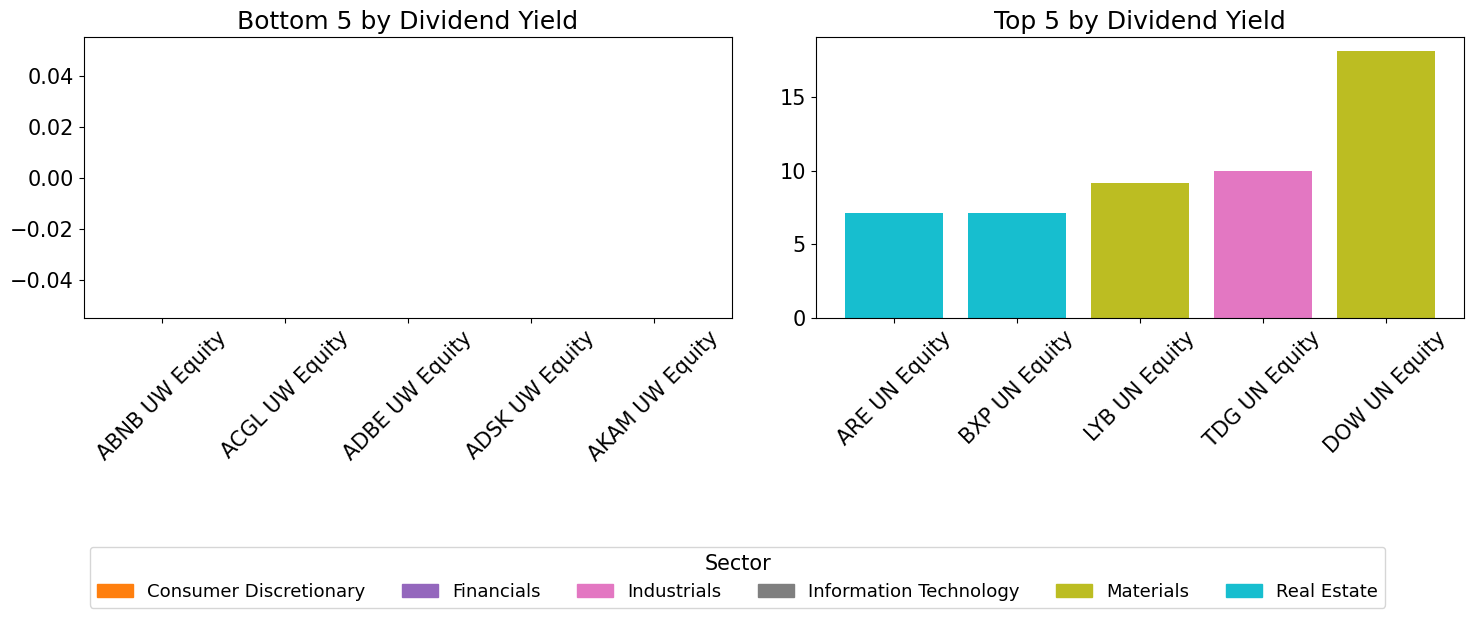

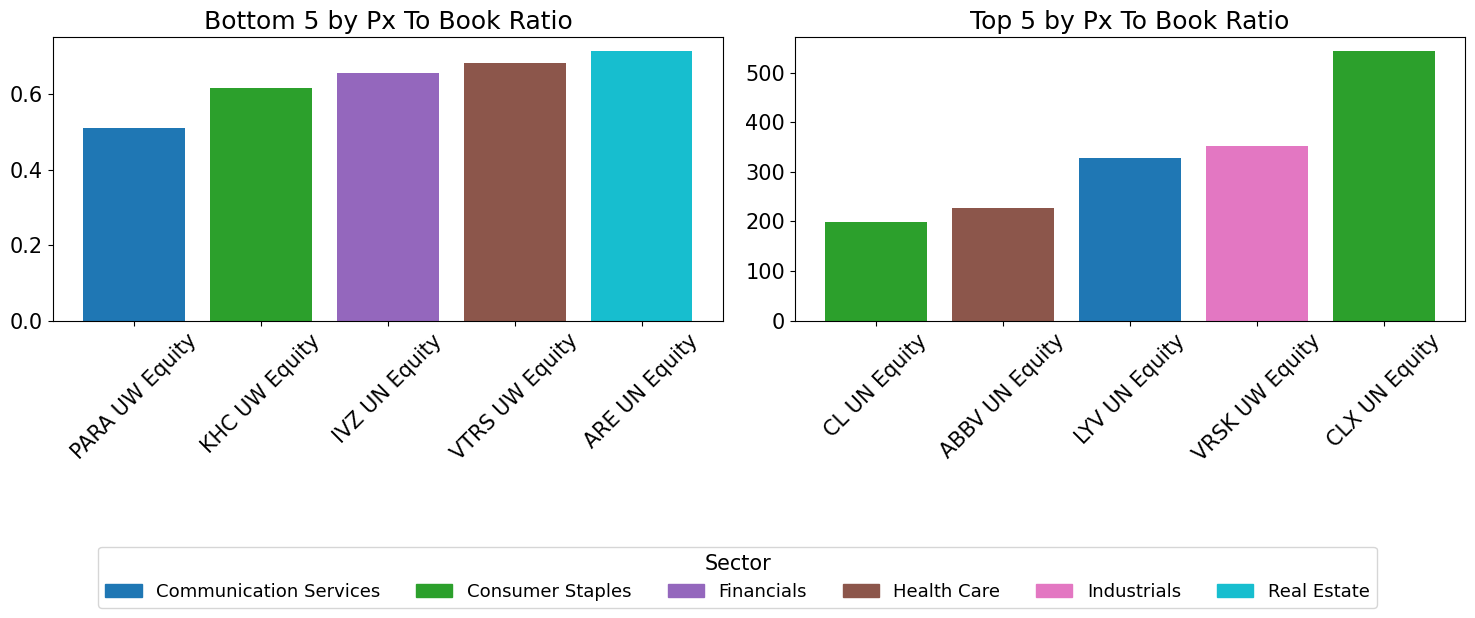

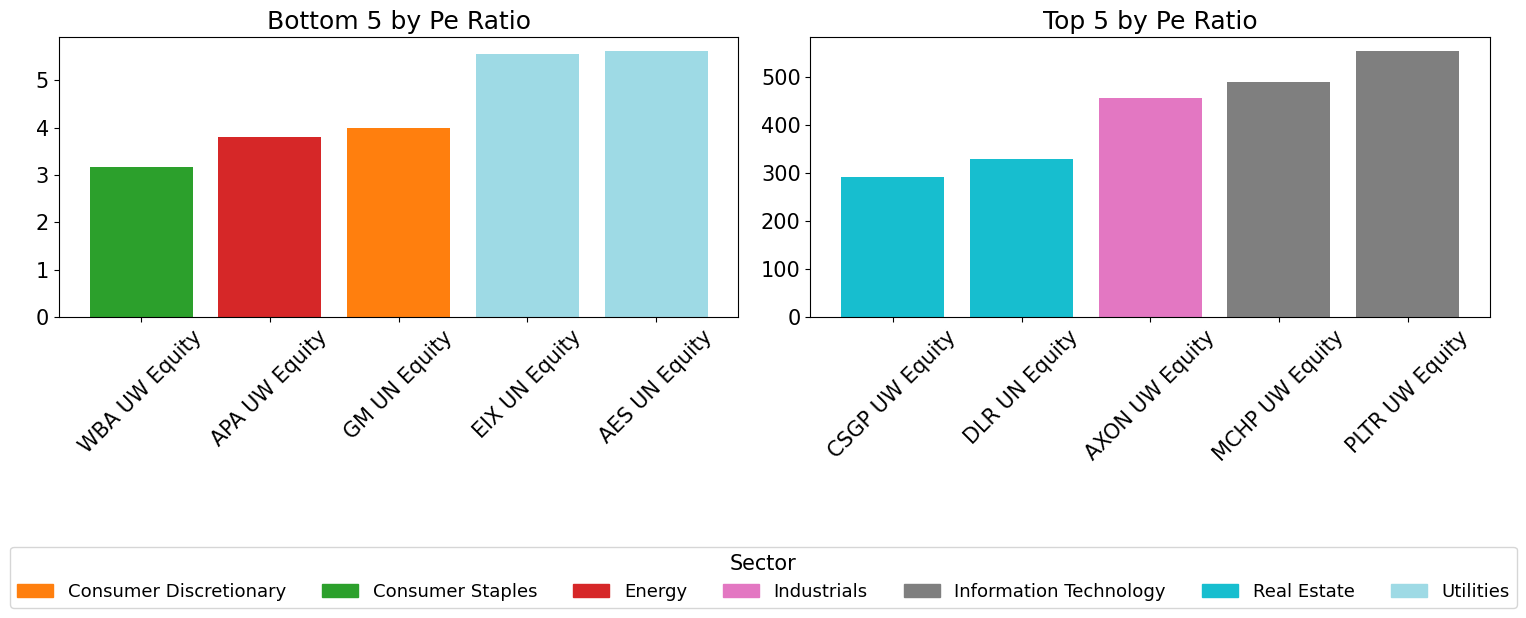

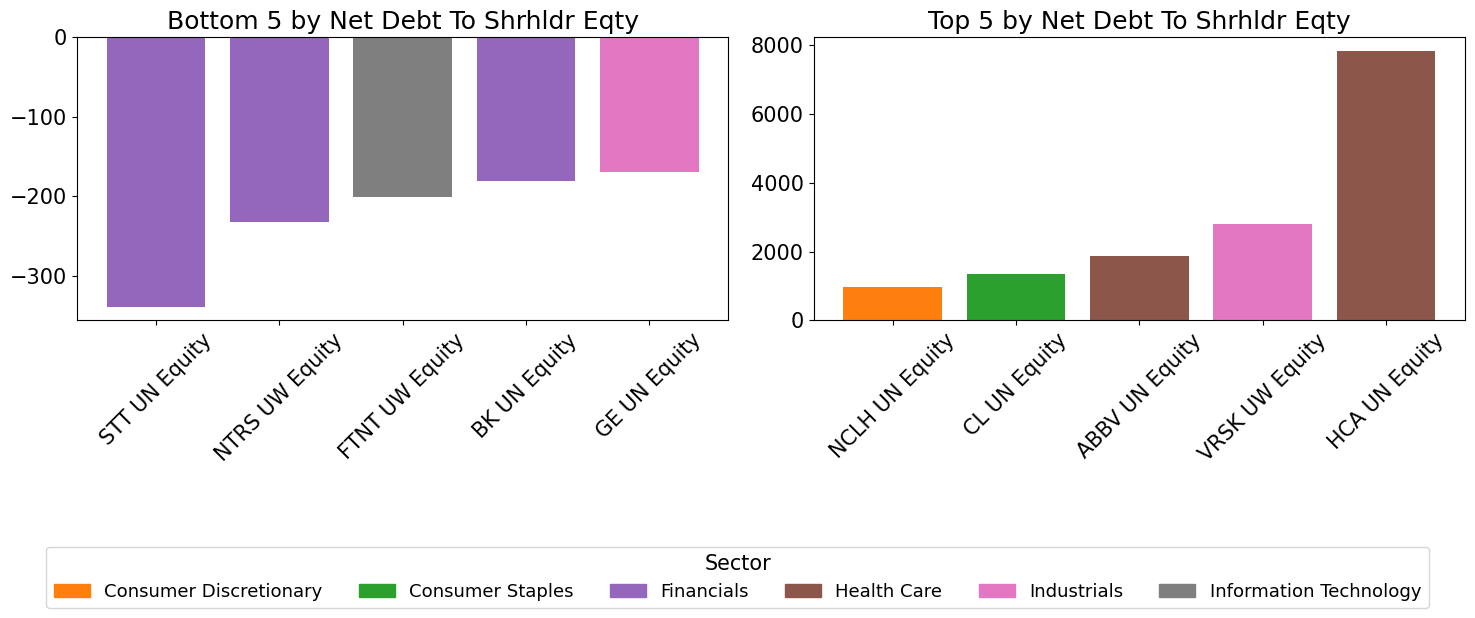

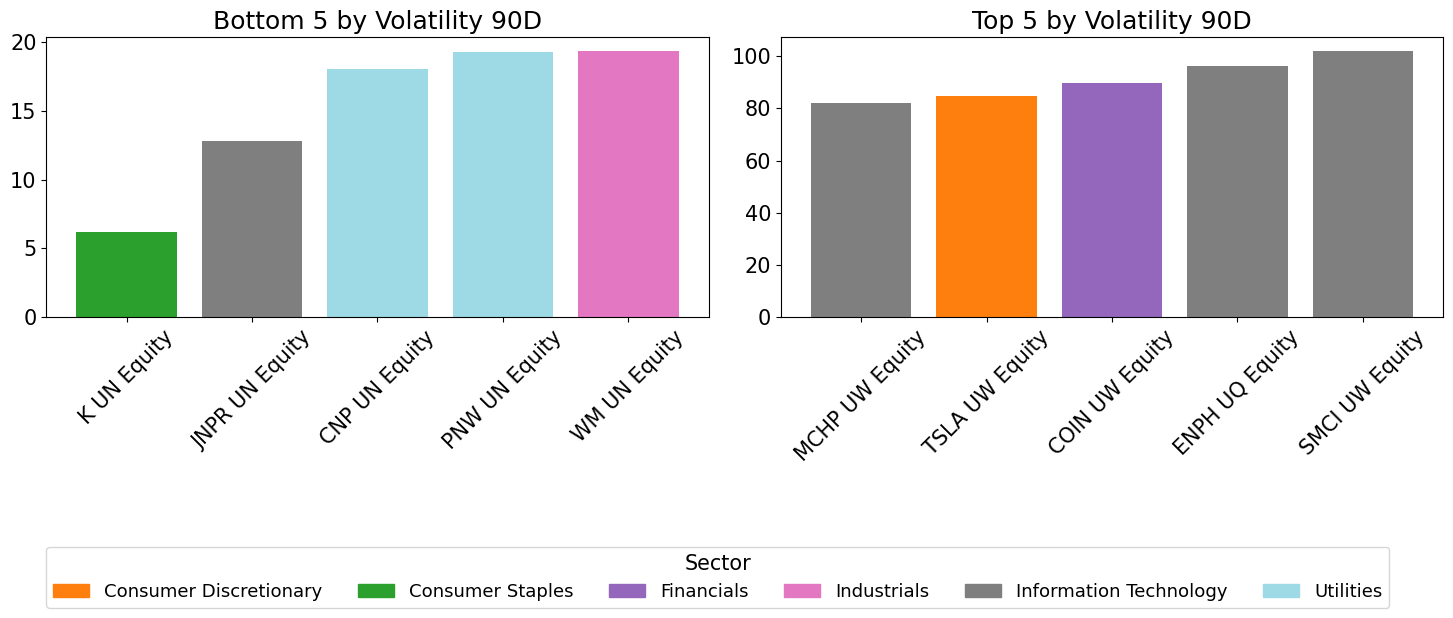

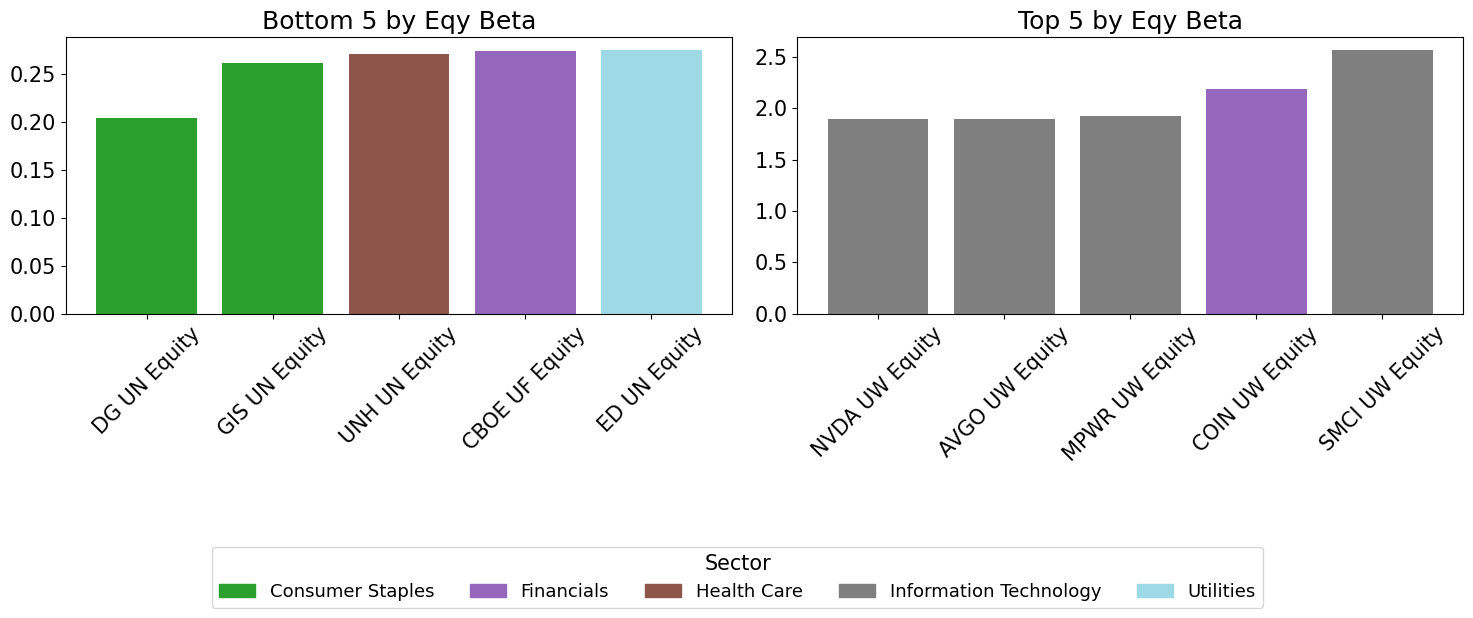

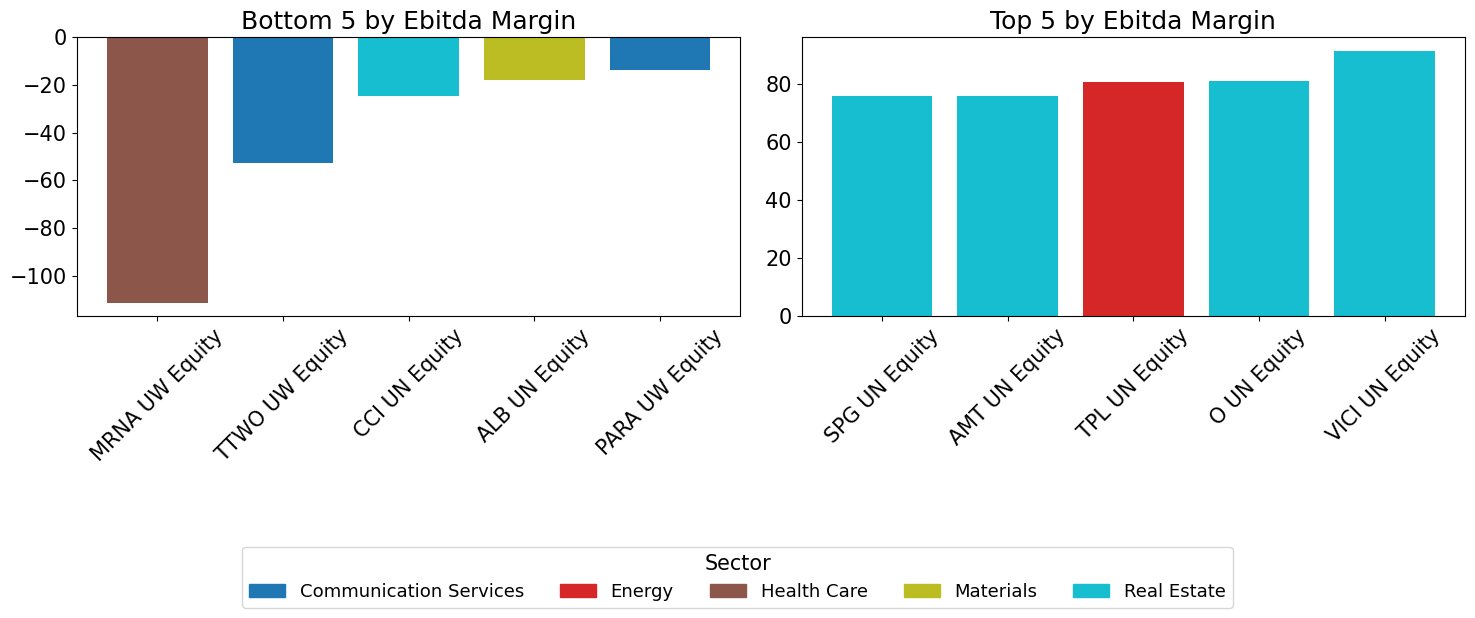

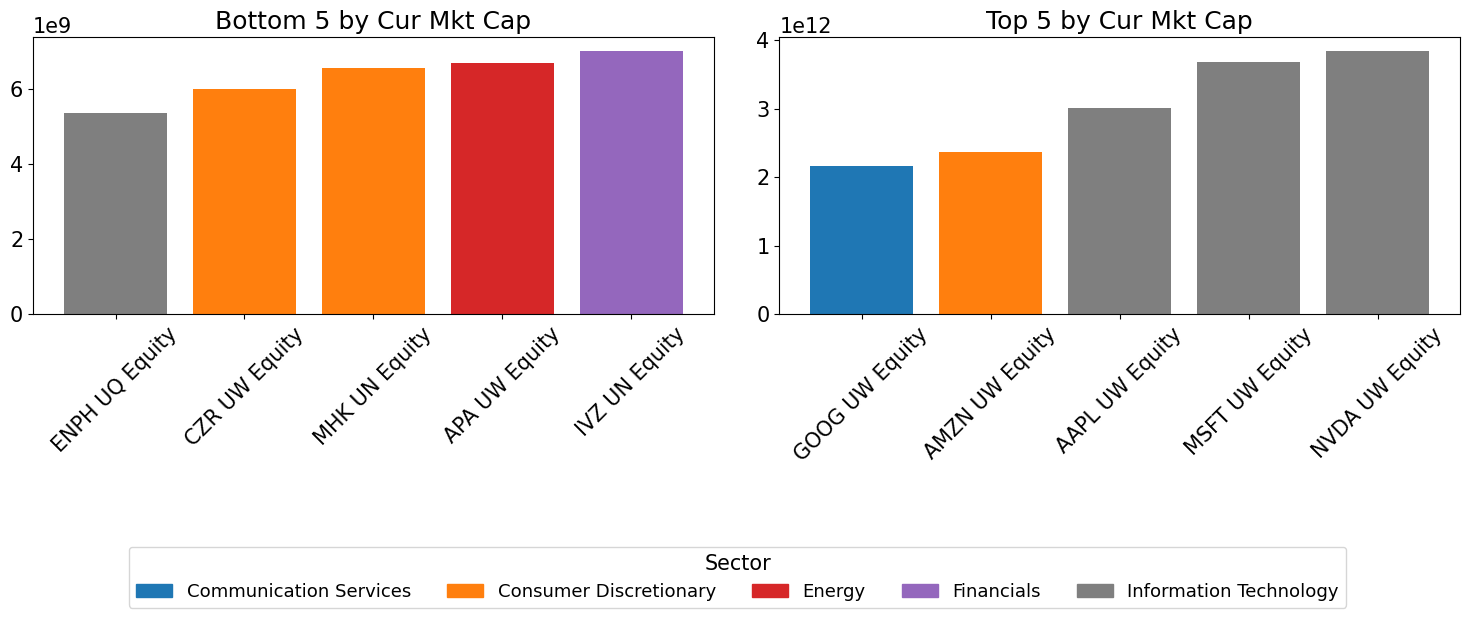

In [ ]:
# ----------------------------------------
# TOP & BOTTOM STOCKS PER METRIC
# ----------------------------------------
ticker_to_sector = bdp_df['gics_sector_name']
for m in metrics:
    if m not in bdp_df.columns: continue
    series = pd.to_numeric(bdp_df[m], errors='coerce').dropna()
    if len(series) < 2: continue
    top5 = series.nlargest(5)
    bot5 = series.nsmallest(5)
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
    bot = bot5.sort_values()
    axes[0].bar(bot.index, bot.values, color=[color_map[ticker_to_sector.loc[t]] for t in bot.index])
    axes[0].set_title(f"Bottom 5 by {m.replace('_', ' ').title()}")
    axes[0].tick_params(axis='x', rotation=45)
    top = top5.sort_values()
    axes[1].bar(top.index, top.values, color=[color_map[ticker_to_sector.loc[t]] for t in top.index])
    axes[1].set_title(f"Top 5 by {m.replace('_', ' ').title()}")
    axes[1].tick_params(axis='x', rotation=45)
    unique_secs = sorted({ticker_to_sector.loc[i] for i in list(bot.index)+list(top.index)})
    handles = [mpatches.Patch(color=color_map[s], label=s) for s in unique_secs]
    fig.legend(handles=handles, title='Sector', bbox_to_anchor=(0.5,-0.1), loc='upper center', ncol=len(handles))
    plt.tight_layout()
    plt.show()